In [2]:
from src.polyG import *
from src.hpggat import *
# from src.smiles_utils import *
import pickle
from torch.utils.data import DataLoader
# from rdkit.Chem.Descriptors import ExactMolWt, MolWt
from torch_geometric.data import Data, Dataset, InMemoryDataset
import torch
from dgl import DGLGraph
import dgl

Using backend: pytorch


In [17]:
processed_df = pd.read_csv("data/processed_electrolytes.csv")
polymerG_cache = pickle.load(open('data/polyG.pt', 'rb'))

In [18]:
polymerhiG_cache = dict()
for pg in polymerG_cache:
    try:
        polymerhiG_cache[pg] = pol2hig_mk2(polymerG_cache[pg])
    except:
        print(pg)

/home/ufslab223/anaconda3/envs/ion/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [19]:
data_list, val_data_list = data_from_df(processed_df, polymerhiG_cache)

In [20]:
train_loader = DataLoader(data_list, batch_size=128, shuffle=True, collate_fn=collate)
val_loader = DataLoader(val_data_list, batch_size=128, shuffle=False, collate_fn=collate)

In [21]:
model = GATNet()

# Model Training

In [ ]:
import tqdm
torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda:1")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)
test_best = 1
epoch_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(1000)):
    epoch_loss = 0
    test_loss =0
    model.train()
    for i, (bg, label) in enumerate(train_loader):
        bg = [_bg.to(device) for _bg in bg]
        label = label.to(device)
        pred = model(bg)
        loss = nn.L1Loss()(pred, label)
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (i + 1)
    model.eval()
    for i, (bg, label) in enumerate(val_loader):
        
        bg = [_bg.to(device) for _bg in bg]
        label = label.to(device)
        pred = model(bg)
        loss = nn.L1Loss()(pred, label)
        test_loss += loss.detach().item()
        
    test_loss /= (i + 1)
        
    if (epoch+1) % 1 == 0:
        print('Epoch {}, loss {:.4f}, val_loss {:4f}'.format(epoch+1, epoch_loss, test_loss))
    epoch_losses.append(epoch_loss)
    test_losses.append(test_loss)
    torch.save(model.state_dict(), f"model_last.bin")
    if test_loss < test_best:
        torch.save(model.state_dict(), f"model_{epoch}_{test_loss}.bin")
        torch.save(model.state_dict(), f"model_best.bin")
        test_best = test_loss
torch.save(model.state_dict(), f"model_last.bin")

# Model Valididataion

In [22]:
model.load_state_dict(torch.load(
        "ckpt/HPG_GAT.bin", map_location=torch.device   ('cpu')))
model.eval()

GATNet(
  (GAT_list_1): ModuleList(
    (0): GAT(
      (W_node): Linear(in_features=49, out_features=1024, bias=False)
      (W_edge): Linear(in_features=1, out_features=8, bias=False)
    )
    (1): GAT(
      (W_node): Linear(in_features=128, out_features=1024, bias=False)
      (W_edge): Linear(in_features=1, out_features=8, bias=False)
    )
    (2): GAT(
      (W_node): Linear(in_features=128, out_features=1024, bias=False)
      (W_edge): Linear(in_features=1, out_features=8, bias=False)
    )
    (3): GAT(
      (W_node): Linear(in_features=128, out_features=1024, bias=False)
      (W_edge): Linear(in_features=1, out_features=8, bias=False)
    )
    (4): GAT(
      (W_node): Linear(in_features=128, out_features=1024, bias=False)
      (W_edge): Linear(in_features=1, out_features=8, bias=False)
    )
    (5): GAT(
      (W_node): Linear(in_features=128, out_features=1024, bias=False)
      (W_edge): Linear(in_features=1, out_features=8, bias=False)
    )
  )
  (linear_g1): Line

In [23]:
train_loader = DataLoader(data_list, batch_size=128, shuffle=False, collate_fn=collate)
val_loader = DataLoader(val_data_list, batch_size=128, shuffle=False, collate_fn=collate)

In [24]:
pred_list=list()
prop_list=list()
val_pred_list=list()
val_prop_list=list()
device = "cuda:0"
model = model.to(device)
for i, (bg, label) in enumerate(train_loader):
    bg = [_bg.to(device) for _bg in bg]
    label = label.to(device)
    pred = model(bg)
    prop_list.extend(label.cpu().numpy())
    pred_list.extend(pred.detach().cpu().numpy())
for i, (bg, label) in enumerate(val_loader):
    bg = [_bg.to(device) for _bg in bg]
    label = label.to(device)
    pred = model(bg)
    val_prop_list.extend(label.cpu().numpy())
    val_pred_list.extend(pred.detach().cpu().numpy())

In [25]:
prop_list = np.array(prop_list)*1.836202-3.981499
pred_list = np.array(pred_list)*1.836202-3.981499
val_prop_list = np.array(val_prop_list)*1.836202-3.981499
val_pred_list = np.array(val_pred_list)*1.836202-3.981499

MAE: 0.16, R2: 0.978
MAE: 0.235, R2: 0.876


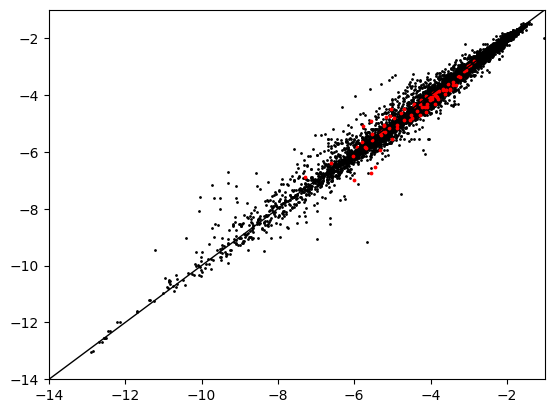

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn import metrics
ax = plt

ax.scatter(prop_list, pred_list, s=1, c='black')
ax.scatter(val_prop_list, val_pred_list, s=3,c='red')
plt.xlim(-14, -1)
plt.ylim(-14, -1)
ax.plot((-14, 0), (-14, 0), c="black", linewidth=1)

train_mae = mean_absolute_error(prop_list,pred_list)
test_mae = mean_absolute_error(val_prop_list, val_pred_list)
train_r2 = r2_score(prop_list,pred_list)
test_r2 = r2_score(val_prop_list, val_pred_list)
print(f"MAE: {train_mae:.2f}, R2: {train_r2:.3f}")
print(f"MAE: {test_mae:.3f}, R2: {test_r2:.3f}")
